# Run Sentiment Analysis on Forum Data
This notebook loads the Youbemom special needs forum text and compares sentiment pre- and during the COVID-19 pandemic

## Data Sources
- youbemomTables.db (scraped with 1-Scrape_Forum.ipynb)

## Changes
- 2020-08-13: Set up data cleaning
- 2020-08-20: Added t-tests
- 2020-08-26: Added plots
- 2020-09-14: Added more plots
- 2020-09-15: Compared parent and child sentiment
- 2020-12-10: Changed data set

## Database Structure
- threads
 - id: automatically assigned
 - url: url of top post
 - subforum: subforum of post
 - dne: post does not exist
- posts
 - id: automatically assigned
 - family_id: thread->id
 - message_id: the unique id of the message from the html
 - parent_id: id of post this post is responding to, 0 if top post
 - date_recorded: date the data is fetched
 - date_created: date the data was created
 - title: title of the post
 - body: body of the post
 - subforum: subforum of post
 - deleted: has post been deleted

## TODO
- Does python have a regression function for continuous dependent variables between 0 and 1 or will I have to use R/Stata for a fractional regression model?
- Set up functions for the plots so I can plug in the variable I want to see
- Does sentiment differ between parents and children in threads?
 - Is sentiment more negative after negative posts? More positive after positive posts?
- Is there a time-dependent function here?
 - Seasonality?
 - Does tweaking the time period cutoffs affect the significance?
- Frequency distribution of words

## Imports

In [2]:
import sqlite3

import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import ttest_ind, kde
from datetime import datetime
# from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer #, word_tokenize
from nltk.corpus import stopwords
import string
import re
from pathlib import Path
import matplotlib.pyplot as plt
import math
from statsmodels.formula.api  import ols
from youbemom import create_connection

## Functions
For formatting the data

In [3]:
def format_data(df):
    """ format the data frame from sql so dates are in
        datetime format and creates text column from
        title and body
    :param df: data frame
    :return df: formatted data frame
    """
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['date_created'] = pd.to_datetime(df['date_created'])
    # text = title + body
    df['title'] = df['title'].replace('This post has been deleted\.', '', regex=True)
    df['text'] = df['title'] + " " + df['body']
    return df

In [4]:
def clean_text(text):
    """ cleans the input text of punctuation, extra
        spaces, and makes letters lower case
    :param text: text (= title + body here)
    :return clean: clean text
    """
    clean = "".join([t for t in text if t not in string.punctuation])
    clean = re.sub(" +", " ", clean)
    clean = clean.strip()
    clean = clean.lower()
    return clean

In [5]:
def remove_stopwords(text):
    """ remove all stop words from the text
        using stopwords from nltk.corpus
    :param text: text with stopwords
    :return words: text without stopwords
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words

For creating the sentiment values

In [6]:
def sentiment_analyzer_scores(sentence, analyzer):
    """ create sentiment scores with the VADER analyzer
    :param sentence: sentence to create scores for
    :param analyzer: VADER sentiment analyzer
    :return score: a dictionary of scores (neg, neu, pos, compound)
    """
    score = analyzer.polarity_scores(sentence)
    return score

For running statistics

In [7]:
def ttest_sentiment(df, v):
    """ run a t-test on the sentiment scores for
        before and during the pandemic
    :param df: data frame
    :param v: the variable name to t-test on
    :return: nothing, prints ttest results
    """
    group_before = df.where(df['before'])[v].dropna()
    group_during = df.where(df['during'])[v].dropna()
    result = ttest_ind(group_before, group_during, equal_var=False, nan_policy="omit")
    print('\n')
    l = len(v)
    print(' '*(l - 8) + 'variable    before    during statistic    pvalue')
    print(v + '  {:1.6f}  {:1.6f} {:+1.6f}  {:1.6f}'.format(group_before.mean(), group_during.mean(), result.statistic, result.pvalue))

For plotting

In [8]:
# None yet

## File Locations

In [9]:
p = Path.cwd()
path_parent = p.parents[0]

In [ ]:
path_db = path_parent / "database" / "youbemom-merged.db"
path_db = str(path_db)

## Load Data

In [10]:
conn = sqlite3.connect(path_db)
df = pd.read_sql_query("SELECT * from posts", conn)

## Format Data
Format the data to make dates into datetimes and create a text column from the title and body. Also, filter the data to include only dates starting Jan. 1, 2019. The scraper picked up one post from 2015 so this removes that. I want to see if there is a difference between parent and child posts so I made an "is_parent" indicator.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16696050 entries, 0 to 16696049
Data columns (total 10 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   id             int64 
 1   family_id      int64 
 2   message_id     object
 3   parent_id      object
 4   date_recorded  object
 5   date_created   object
 6   title          object
 7   body           object
 8   subforum       object
 9   deleted        int64 
dtypes: int64(3), object(7)
memory usage: 1.2+ GB


In [12]:
df = format_data(df)

In [ ]:
# df = df[(df['date_created']>pd.Timestamp(2019,1,1))]

In [13]:
df['before'] = df['date_created'] <= pd.Timestamp(2020,2,28)
df['during'] = df['date_created'] >= pd.Timestamp(2020,4,1)
df['march'] = ~df['before'] & ~df['during']
df.loc[df['before'], 'period'] = 'before'
df.loc[df['march'], 'period'] = 'march'
df.loc[df['during'], 'period'] = 'during'

In [14]:
df['is_parent'] = df['parent_id'] == ""

In [15]:
df['weekday'] = df['date_created'].dt.day_name()

In [17]:
df['week_n'] = df['date_created'].dt.isocalendar().week

In [18]:
df['weekday_n'] = df['date_created'].dt.day

In [19]:
df['month'] = df['date_created'].dt.month_name()

In [20]:
df['month_n'] = df['date_created'].dt.month

## Add Sentiment Scores

In [21]:
analyzer = SentimentIntensityAnalyzer()

With the text as collected:

In [22]:
sentiment = df['text'].apply(lambda x: sentiment_analyzer_scores(x, analyzer))

In [23]:
df['neg_sentiment'] = sentiment.apply(lambda x: x.get('neg', 0))
df['neu_sentiment'] = sentiment.apply(lambda x: x.get('neu', 0))
df['pos_sentiment'] = sentiment.apply(lambda x: x.get('pos', 0))
df['compound_sentiment'] = sentiment.apply(lambda x: x.get('compound', 0))

Example sentiment:

In [25]:
sentiment[5]

{'neg': 0.0, 'neu': 0.747, 'pos': 0.253, 'compound': 0.5267}

I can also do this without stop words or punctuation but VADER includes puctuation in sentiment calculation. "!", ALLCAPS, and degree modifiers (like "extremely" or "marginally") affects the magnitude of a sentiment. Conjunctions like "but" can flip the sentiment polarity. Below, we can see that the shift in sentiment is the same whether or not we include stop words, pucntuation, and lowercase everything but I'll use the as-collected text instead of the clean text in the rest of the analysis.

In [26]:
df.to_sql('posts', conn, if_exists='replace', index=False)

## Statistical Analysis
This test looks at whether the average sentiment is different before (up to Feb. 28, 2020) and during the pandemic (after April 1, 2020)

In [20]:
ttest_sentiment(df, 'neg_sentiment')
ttest_sentiment(df, 'neu_sentiment')
ttest_sentiment(df, 'pos_sentiment')
ttest_sentiment(df, 'compound_sentiment')



     variable    before    during statistic    pvalue
neg_sentiment  0.087093  0.089268 -23.138229  0.000000


     variable    before    during statistic    pvalue
neu_sentiment  0.772647  0.768901 +25.581447  0.000000


     variable    before    during statistic    pvalue
pos_sentiment  0.124709  0.119449 +46.756564  0.000000


          variable    before    during statistic    pvalue
compound_sentiment  0.056931  0.040543 +75.963844  0.000000


With or with out stop words, the results show that sentiment is both more negative and less positive (p < 0.05 at least in all cases) during the pandemic compared to before the pandemic.

How about comparing sentiment of parent posts to its children? If I compare the average child sentiment to the top post of each thread:

In [21]:
parents = df[df["is_parent"]]
parents = parents[["family_id","neg_sentiment","pos_sentiment","compound_sentiment","before","during"]]
children = df[~df["is_parent"]]
children = children[["family_id","neg_sentiment","pos_sentiment","compound_sentiment"]]
children.info()
children_ave = children.groupby("family_id", as_index=False).mean()
compare = pd.merge(left=parents, right=children_ave, on="family_id", how="inner", suffixes=['_p','_c'])
compare.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14940572 entries, 1 to 16474569
Data columns (total 4 columns):
 #   Column              Dtype  
---  ------              -----  
 0   family_id           int64  
 1   neg_sentiment       float64
 2   pos_sentiment       float64
 3   compound_sentiment  float64
dtypes: float64(3), int64(1)
memory usage: 569.9 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1352518 entries, 0 to 1352517
Data columns (total 9 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   family_id             1352518 non-null  int64  
 1   neg_sentiment_p       1352518 non-null  float64
 2   pos_sentiment_p       1352518 non-null  float64
 3   compound_sentiment_p  1352518 non-null  float64
 4   before                1352518 non-null  bool   
 5   during                1352518 non-null  bool   
 6   neg_sentiment_c       1352518 non-null  float64
 7   pos_sentiment_c       1352518 non-null  fl

In [22]:
compare['pos_diff'] = compare['pos_sentiment_p'] - compare['pos_sentiment_c']
compare['neg_diff'] = compare['neg_sentiment_p'] - compare['neg_sentiment_c']
compare['compound_diff'] = compare['compound_sentiment_p'] - compare['compound_sentiment_c']
compare.head()

,family_id,neg_sentiment_p,pos_sentiment_p,compound_sentiment_p,before,during,neg_sentiment_c,pos_sentiment_c,compound_sentiment_c,pos_diff,neg_diff,compound_diff
0,1,0.363,0.000,-0.6113,True,False,0.142000,0.082500,0.070125,-0.082500,0.221000,-0.681425
1,2,0.000,0.253,0.5267,True,False,0.241000,0.064800,-0.009840,0.188200,-0.241000,0.536540
2,3,0.000,0.000,0.0000,True,False,0.549500,0.061000,-0.853600,-0.061000,-0.549500,0.853600
3,5,0.111,0.166,0.2498,True,False,0.006444,0.193694,0.247608,-0.027694,0.104556,0.002192
4,6,0.000,0.255,0.3400,True,False,0.000000,0.350333,0.612567,-0.095333,0.000000,-0.272567


In [23]:
est_pos = ols(formula = 'pos_sentiment_c ~ pos_sentiment_p', data = compare).fit()
print(est_pos.summary())
est_neg = ols(formula = 'neg_sentiment_c ~ neg_sentiment_p', data = compare).fit()
print(est_neg.summary())
est_compound = ols(formula = 'compound_sentiment_c ~ compound_sentiment_p', data = compare).fit()
print(est_compound.summary())

                            OLS Regression Results                            
Dep. Variable:        pos_sentiment_c   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                 1.586e+04
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        18:47:51   Log-Likelihood:             8.4503e+05
No. Observations:             1352518   AIC:                        -1.690e+06
Df Residuals:                 1352516   BIC:                        -1.690e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1232      0.000    8

So this suggests if a parent comment's negative sentiment increases, the children's negative sentiment will increase as well. Perhaps redo this analysis on each observation rather than the average children's sentiment.

## Plots
Density plot comparing compound sentiment before and during the pandemic

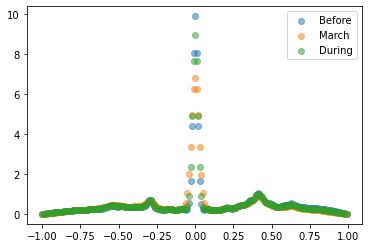

In [24]:
density_before = kde.gaussian_kde(df["compound_sentiment"][df['before']])
density_march = kde.gaussian_kde(df["compound_sentiment"][df['march']])
density_during = kde.gaussian_kde(df["compound_sentiment"][df['during']])
x = np.arange(-1.0, 1.0, 0.01)
plt.scatter(x, density_before(x), alpha=0.5, label="Before")
plt.scatter(x, density_march(x), alpha=0.5, label="March")
plt.scatter(x, density_during(x), alpha=0.5, label="During")
plt.legend(loc="upper right")
plt.show()

Scatter plot comparing daily average before and during the pandemic

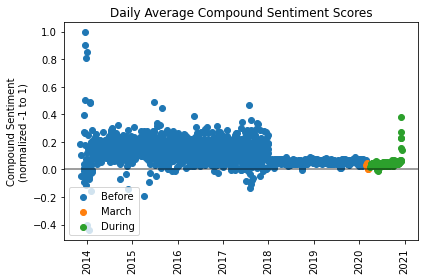

In [27]:
df['day'] = pd.to_datetime(df['date_created'], format="%Y-%m-%d")
daily_ave = df.resample('d', on='day').mean().dropna(how='all')
daily_ave['before'] = daily_ave.index <= pd.Timestamp(2020,2,28)
daily_ave['during'] = daily_ave.index >= pd.Timestamp(2020,4,1)
daily_ave['march'] = ~daily_ave['before'] & ~daily_ave['during']
plt.scatter(daily_ave.index[daily_ave['before']], daily_ave['compound_sentiment'][daily_ave['before']], label="Before")
plt.scatter(daily_ave.index[daily_ave['march']], daily_ave['compound_sentiment'][daily_ave['march']], label="March")
plt.scatter(daily_ave.index[daily_ave['during']], daily_ave['compound_sentiment'][daily_ave['during']], label="During")
plt.legend(loc="lower left")
plt.xticks(rotation=90)
plt.ylabel('Compound Sentiment\n(normalized -1 to 1)')
plt.title('Daily Average Compound Sentiment Scores')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.tight_layout()
plt.savefig('../plots/daily_ave_compound_sentiment.png')

plt.show()

In [34]:
daily_ave[daily_ave['during']].sort_values(by='compound_sentiment', ascending=False).head(20)

,id,family_id,deleted,before,during,march,is_parent,week_n,weekday_n,month_n,neg_sentiment,neu_sentiment,pos_sentiment,compound_sentiment
day,,,,,,,,,,,,,,
2020-12-05,9.161524e+06,8.413092e+05,0.157895,False,True,False,0.684211,49,5.0,12.0,0.035632,0.641579,0.164842,0.377558
2020-12-03,1.330615e+07,1.235424e+06,0.150000,False,True,False,0.150000,49,3.0,12.0,0.085050,0.658450,0.106400,0.273780
2020-12-06,9.041531e+06,8.275659e+05,0.041667,False,True,False,0.791667,49,6.0,12.0,0.030542,0.865208,0.062542,0.227813
2020-12-07,1.121383e+07,1.034358e+06,0.071429,False,True,False,0.785714,50,7.0,12.0,0.060714,0.776857,0.091036,0.225414
2020-12-04,1.359924e+07,1.262725e+06,0.181818,False,True,False,0.181818,49,4.0,12.0,0.039212,0.702636,0.076303,0.154700
2020-12-08,1.226701e+07,1.130528e+06,0.000000,False,True,False,0.800000,50,8.0,12.0,0.021600,0.949400,0.029000,0.140840
2020-11-26,1.557969e+07,1.454376e+06,0.037225,False,True,False,0.116907,48,26.0,11.0,0.080746,0.753529,0.128501,0.071985
2020-12-02,1.566255e+07,1.461998e+06,0.015628,False,True,False,0.094763,49,2.0,12.0,0.079028,0.783524,0.121819,0.067777
2020-09-25,1.436578e+07,1.330197e+06,0.021206,False,True,False,0.086180,39,25.0,9.0,0.083506,0.768570,0.126718,0.065862


Seasonality

In [38]:
weekday_ave_sn = df[df['subforum']=='special-needs'].groupby(['weekday'])['compound_sentiment'].mean()
path_weekday_sen_sn = path_parent / "clean_data" / "weekday_sentiment_special-needs.csv"
path_weekday_sen_sn = str(path_weekday_sen_sn)
weekday_ave_sn.to_csv(path_weekday_sen_sn)

In [39]:
weekday_ave_tod = df[df['subforum']=='toddler'].groupby(['weekday'])['compound_sentiment'].mean()
path_weekday_sen_tod = path_parent / "clean_data" / "weekday_sentiment_toddler.csv"
path_weekday_sen_tod = str(path_weekday_sen_tod)
weekday_ave_tod.to_csv(path_weekday_sen_tod)

In [ ]:
ax = weekday_ave.plot(kind='bar');
ax.set_title("Average Sentiment by Weekday")
ax.set_ylabel("Compound Sentiment\n(normalized -1 to 1)");
plt.show()

Sentiment is more negative and less positive during the pandemic

In [ ]:
fig, ax = plt.subplots()
width = 0.35
sentiments = ['Negative', 'Positive']
x_pos = np.arange(len(sentiments))

before_mean = [df["neg_sentiment"][df['before']].mean(),
               df["pos_sentiment"][df['before']].mean()]
before_se = [df["neg_sentiment"][df['before']].std()/math.sqrt(len(df["neg_sentiment"][df['before']])),
             df["pos_sentiment"][df['before']].std()/math.sqrt(len(df["pos_sentiment"][df['before']]))]
during_mean = [df["neg_sentiment"][df['during']].mean(),
               df["pos_sentiment"][df['during']].mean()]
during_se = [df["neg_sentiment"][df['during']].std()/math.sqrt(len(df["neg_sentiment"][df['during']])),
             df["pos_sentiment"][df['during']].std()/math.sqrt(len(df["pos_sentiment"][df['during']]))]

rects_before = ax.bar(x_pos - width/2, before_mean, width, yerr=before_se,
                label='Before', capsize=5, color="cornflowerblue")
rects_during = ax.bar(x_pos + width/2, during_mean, width, yerr=during_se,
                label='During', capsize=5, color="indianred")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Sentiment Score\n(normalized 0 to 1)')
ax.set_title('Comparison of Sentiment Scores')
ax.set_xticks(x_pos)
ax.set_xticklabels(sentiments)
ax.legend()
fig.tight_layout()
plt.savefig('../plots/sentiment_neg_pos.png')
plt.show()

## Save Clean Data in New Database

In [ ]:
df.to_sql('sentiments', conn, if_exists='replace', index=False)